#**Sentiment Analysis on hotel Hilton, San Francisco, CA**







##**Methodologies**

**Web Scraping**

The hotel reviews will be scraped from bookings.com by using requests with BeautifulSoup.

**Exploratory Data Analysis (EDA)**

Pie chart, histogram plot to get a better understanding of the reviews and ratings data.

**WordClouds**

Word counts for the positive and negative words.

**Sentiment Analysis**

The sentiment analysis helps to classify the polarity and subjectivity of the overall reviews and determine whether the expressed opinion in the reviews is mostly positive, negative, or neutral.

**Classification and Training Model**

GradientBoostingClassfier

RandomForestClassifer

**LDA Topic Model**

In natural language processing, the latent Dirichlet allocation is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. We will use GridSearch to find the best topic model.

#**Objective**

**The objective is to use text analytics and Natural Language Processing (NLP) to extract actionable insights from the reviews and help the hotel improve their guest satisfactions.**

###**Importing the required packages**

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import re

from bs4 import BeautifulSoup as bs
import requests


import string
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords,wordnet 
from wordcloud import WordCloud
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



#**Scraping Data**

Scraping Reviews from Bookings.com

The hotel I have choosen is "Hotel Hilton," San Francisco, CA.

The scraped data includes:

Basic information of the reviewer and reviews:

Rating Score

Reviewer Name

Reviewer's Nationality

Overall Review (contains both positive & negative reviews)

Reviewer Reviewed Times

Review Date

Review Tags like Trip type, such as business trip, leisure trip

Positive reviews

Negative reviews

In [ ]:

def scrape_reviews(hotel_linkname,total_pages):
    '''
    Function to scrape hotel reviews from bookings.com
    INPUTS:
        hotel_linkname - hotel name in the bookings.com weblink
        total_pages - the total number of reviews pages to scrape
    OUTPUTS:
        reviewer_info - a dataframe that includes reviewers' basic information
        pos_reviews -  a dataframe that includes all the positive reviews 
        neg_reviews - a dataframe that includes all the negative reviews
    '''
    #Create empty lists to put in reviewers' information as well as all of the positive & negative reviews 
    info = []
    positive = []
    negative = []
    
    #bookings.com reviews link
    url = 'https://www.booking.com/reviews/us/hotel/'+ hotel_linkname +'.html?page=' +'r_lang=en&customer_type=total&order=featuredreviews'
    page_number = 1

    #Use a while loop to scrape all the pages 
    while page_number <= total_pages:

        page = requests.get(url + str(page_number)) #retrieve data from serve
        soup = bs(page.text, "html.parser") # initiate a beautifulsoup object using the html source and Python’s html.parser
        review_box = soup.find('ul',{'class':'review_list'})

        #ratings
        ratings = [i.text.strip() for i in review_box.find_all('span',{'class':'review-score-badge'})]
        
        #reviewer_info
        reviewer_info = [i.text.strip() for i in review_box.find_all('span',{'itemprop':'name'})]
        reviewer_name = reviewer_info[0::3]
        reviewer_country = reviewer_info[1::3]
        general_review = reviewer_info[2::3]

        # reviewer_review_times
        review_times = [i.text.strip() for i in review_box.find_all('div',{'class':'review_item_user_review_count'})]

        # review_date
        review_date = [i.text.strip().strip('Reviewed: ') for i in review_box.find_all('p',{'class':'review_item_date'})]

        # reviewer_tag
        reviewer_tag = [i.text.strip().replace('\n\n\n','').replace('•',',').lstrip(', ') for i 
                        in review_box.find_all('ul',{'class':'review_item_info_tags'})]

        # positive_review
        positive_review = [i.text.strip('눇').strip() for i in review_box.find_all('p',{'class':'review_pos'})]

        # negative_review
        negative_review = [i.text.strip('눉').strip() for i in review_box.find_all('p',{'class':'review_neg'})]

        # append all reviewers' info into one list
        for i in range(len(reviewer_name)):
            info.append([ratings[i],reviewer_name[i],reviewer_country[i],general_review[i], 
                         review_times[i],review_date[i],reviewer_tag[i]])

        # build positive review list
        for i in range(len(positive_review)):
            positive.append(positive_review[i])

        # build negative review list
        for i in range(len(negative_review)):
            negative.append(negative_review[i])

        # page change
        page_number +=1

    #Reviewer_info df
    reviewer_info = pd.DataFrame(info,
                        columns = ['Rating','Name','Country','Overall_review','Review_times','Review_date','Review_tags'])
    reviewer_info['Rating'] = pd.to_numeric(reviewer_info['Rating'] )
    reviewer_info['Review_times'] = pd.to_numeric(reviewer_info['Review_times'].apply(lambda x:re.findall("\d+", x)[0]))
    reviewer_info['Review_date'] = pd.to_datetime(reviewer_info['Review_date'])
    
    #positive & negative reviews dfs
    pos_reviews = pd.DataFrame(positive,columns = ['positive_reviews'])
    neg_reviews = pd.DataFrame(negative,columns = ['negative_reviews'])
    
    return reviewer_info, pos_reviews, neg_reviews

def show_data(df):
    print("The length of the dataframe is: {}".format(len(df)))
    print("Total NAs: {}".format(df.isnull().sum().sum()))
    return df.head()

In [ ]:
df_reviewers_info, df_pos_reviews, df_neg_reviews = scrape_reviews('hilton-san-francisco-financial-district',total_pages = 45)

###**Reviewers Info**

In [ ]:
show_data(df_reviewers_info)

The length of the dataframe is: 1080
Total NAs: 0


,Rating,Name,Country,Overall_review,Review_times,Review_date,Review_tags
0,8.0,Dale,New Zealand,Very Good,4,2021-12-01,"Business trip, Solo traveler, King Room, Staye..."
1,8.0,Ezra,United States of America,Very Good,2,2021-11-28,"Leisure trip, Family with young children, Doub..."
2,8.0,Cornejo,United States of America,I felt the parking was strategically expensive...,2,2021-11-21,"Leisure trip, Family with young children, Doub..."
3,6.0,Halle,United States of America,Our stay was pleasant. We were only there for ...,1,2021-11-19,"Leisure trip, Couple, Queen Room with Bay View..."
4,8.0,Joel,United States of America,overall a great stay and the location was grea...,10,2021-11-10,"Leisure trip, Family with young children, Doub..."


###**Positive Reviews**

In [ ]:
show_data(df_pos_reviews)

The length of the dataframe is: 900
Total NAs: 0


,positive_reviews
0,great location
1,Clean bedding \nlocation \nview from 22nd floor
2,Location was central so could walk to lots of ...
3,was close to where I was wanting to be
4,Close proximity to wharf and China town


###**Negative Reviews**

In [ ]:
show_data(df_neg_reviews)

The length of the dataframe is: 1035
Total NAs: 0


,negative_reviews
0,shame the restaurants were not open
1,"Only 4 elevators,\nForced to wait 15-20min"
2,very high parking fee \nno microwave \nno fridge
3,Hotel could use some general upkeep. Chipped p...
4,staff was a little stuffy at first could be ki...


###**Pickled the Dataset**

Pickled the data and stored in the google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
filename = '/content/drive/MyDrive/DataMining/ShortStory/reviewer_info.sav'
pickle.dump(df_reviewers_info, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/MyDrive/DataMining/ShortStory/pos_reviews.sav'
pickle.dump(df_pos_reviews, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/MyDrive/DataMining/ShortStory/neg_reviews.sav'
pickle.dump(df_neg_reviews, open(filename, 'wb'))

###**Displaying the total number of reviews that we have for the analyzes**

In [ ]:
def show_data(df):
    print("The length of the dataframe is: {}".format(len(df)))
    print("Total NAs: {}".format(df_reviewers_info.isnull().sum().sum()))
    return df.head()

In [ ]:
print("The length of the dataframe is: {}".format(len(df_reviewers_info)))

print("Total NAs: {}".format(df_reviewers_info.isnull().sum().sum()))

The length of the dataframe is: 1080
Total NAs: 0


In [ ]:
print("The length of the dataframe is: {}".format(len(df_pos_reviews)))

print("Total NAs: {}".format(df_pos_reviews.isnull().sum().sum()))

The length of the dataframe is: 900
Total NAs: 0


In [ ]:
print("The length of the dataframe is: {}".format(len(df_neg_reviews)))

print("Total NAs: {}".format(df_neg_reviews.isnull().sum().sum()))

The length of the dataframe is: 1035
Total NAs: 0


##**Exploratory Data Analysis (EDA)**

###**Ratio of positive and negative reviews**

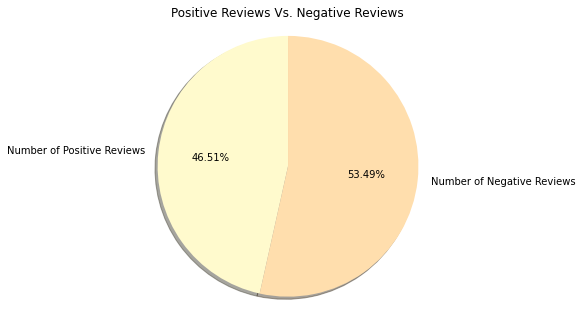

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = [len(df_pos_reviews), len(df_neg_reviews)]

ax.pie(values, 
       labels = ['Number of Positive Reviews', 'Number of Negative Reviews'],
       colors=['lemonchiffon', 'navajowhite'],
       shadow=True,
       startangle=90, 
       autopct='%1.2f%%')
ax.axis('equal')
plt.title('Positive Reviews Vs. Negative Reviews');

###**The Distribution of Ratings**

Creating Histogram of ratings

In [ ]:
# Histogram of Ratings
print(df_reviewers_info['Rating'].describe())
px.histogram(df_reviewers_info, x="Rating", nbins=30, title = 'Histogram of Ratings')

count    1080.000000
mean        7.708333
std         0.889192
min         6.000000
25%         7.000000
50%         8.000000
75%         8.000000
max         9.000000
Name: Rating, dtype: float64


*The histogram rating is left skewed*

In [ ]:
top10_df = df_reviewers_info.groupby('Country').size().reset_index().sort_values(0, ascending = False).head(10)
top10_df.columns = ['Country', 'Counts']


In [ ]:
#Define tag list
tag_list = ['Business','Leisure','Group','Couple','Family','Solo']

#Count for each review tag
tag_counts = []
for tag in tag_list:
    counts = df_reviewers_info['Review_tags'].str.count(tag).sum()
    tag_counts.append(counts)

#Convert to a dataframe
trip_type = pd.DataFrame({'Trip Type':tag_list,'Counts':tag_counts}).sort_values('Counts',ascending = False)

#Visualize the trip type counts from Review_tags
fig = px.bar(trip_type, x='Trip Type', y='Counts', title='Review Tags Counts for each Trip Type')
fig.show()

##**Text Analytics**

Lemmatize Tokens

Lemmatization links words with similar meaning to one word.Used NLTK to lemmatize words.

In [ ]:
# Create a function to define a mapping between wordnet tags and POS tags 
def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        return wordnet.ADJ 

    elif pos_tag.startswith('V'):
        return wordnet.VERB 

    elif pos_tag.startswith('N'):
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN # default, return wordnet tag "NOUN"

#Create a function to lemmatize tokens in the reviews
def lemmatized_tokens(text):
        text = text.lower()
        pattern = r'\b[a-zA-Z]{3,}\b'                 
        tokens = nltk.regexp_tokenize(text, pattern) # tokenize the text
        tagged_tokens = nltk.pos_tag(tokens)  # a list of tuples (word, pos_tag)
          
        stop_words = stopwords.words('english')
        new_stopwords = ["hotel","everything","anything","nothing","thing","need",
                        "good","great","excellent","perfect","much","even","really"]  #customize extra stop_words
        stop_words.extend(new_stopwords)
        stop_words = set(stop_words)
        
        wordnet_lemmatizer = WordNetLemmatizer()
        # get lemmatized tokens                             #call function "get_wordnet_pos"
        lemmatized_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) 
                  # tagged_tokens is a list of tuples (word, tag)
                  for (word, tag) in tagged_tokens \
                  # remove stop words
                  if word not in stop_words and \
                  # remove punctuations
                  word not in string.punctuation]

        return lemmatized_words


###**Generate WordClouds**

Defined a function that would run for both positive and negative reviews and plot the wordclouds

In [ ]:
def wordcloud(review_df, review_colname, color, title):
    text = review_df[review_colname].tolist()
    text_str = ' '.join(lemmatized_tokens(' '.join(text))) #call function "lemmatized_tokens"
    wordcloud = WordCloud(collocations = False,
                          background_color = color,
                          width=1600, 
                          height=800, 
                          margin=2,
                          min_font_size=20).generate(text_str)

    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,title,fontsize = 20, ha='center')
    
    return plt.show()

In [ ]:
df_pos_reviews.dtypes

positive_reviews    object
dtype: object

Removing the NA values from the reviews

In [ ]:
# df_pos_reviews = df_pos_reviews.notna
df_pos_reviews
df_pos_reviews = df_pos_reviews.dropna()
df_pos_reviews

,positive_reviews
0,great location
1,Clean bedding \nlocation \nview from 22nd floor
2,Location was central so could walk to lots of ...
3,was close to where I was wanting to be
4,Close proximity to wharf and China town
...,...
895,too expensive parking 60 dollars a night is to...
896,Quiet and Comfy
897,Location was wonderful and staff friendly and...
898,We were here for the SF marathon. Location was...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


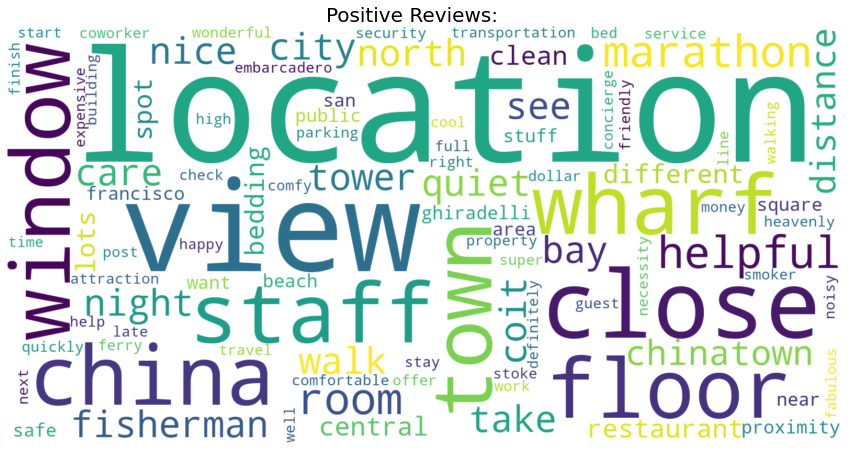

In [ ]:
# Wordcoulds for Positive Reviews
nltk.download('averaged_perceptron_tagger')

nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')
# nltk.download('wordnet')
nltk.download('wordnet')
wordcloud(df_pos_reviews,'positive_reviews', 'white','Positive Reviews:')

###**Positive reviews Result**

From the above plot, we can conclude that most people are probably satisfied with the location, very convenient, comfortable and close to Union Square or Chinatown.

Easy to find restaurants or pubs nearby, friendly and helpful staff

Clean room, comfortable bed, and good price, etc.

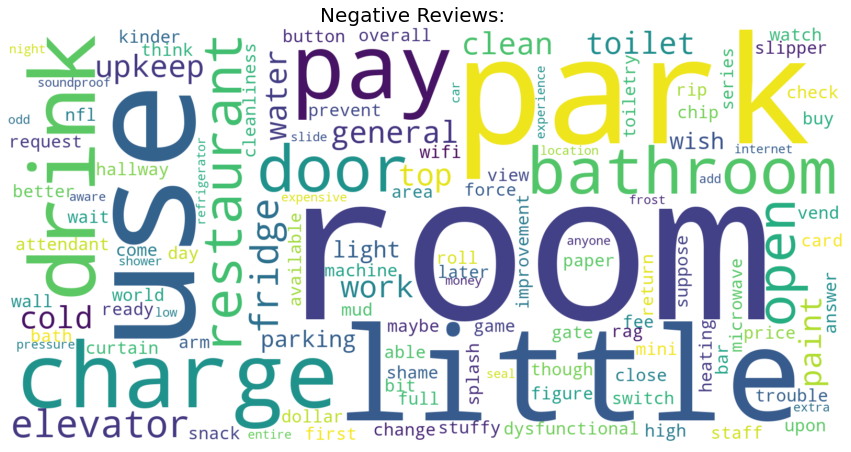

In [ ]:
df_neg_reviews = df_neg_reviews.dropna()
df_neg_reviews
wordcloud(df_neg_reviews,'negative_reviews', 'white','Negative Reviews:')

###**Negative Review Outcome**

Words like “breakfast”, “room” and “staff” are mentioned quite often, which indicates that maybe people were complaining about the staffs who were being rude, small rooms, and coffee/ cereal/ muffin provided during breakfast. 

The air conditioning or the shower system may need improvements as we see words like “hot”, “cold”, “air”, “condition”, “bathroom” and “shower” in the WordCloud.

The hotel may also need to solve issues related to soundproofing and parking.


##**Sentiment Analysis**

**Using the Overall_review column in the df_reviewer_info dataframe to perform the sentiment analysis.**

In [ ]:

#Create a function to get the subjectivity
def subjectivity(text): 
    return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def polarity(text): 
    return TextBlob(text).sentiment.polarity

#Create two new columns
df_reviewers_info['Subjectivity'] = df_reviewers_info['Overall_review'].apply(subjectivity)
df_reviewers_info['Polarity'] = df_reviewers_info['Overall_review'].apply(polarity)

In [ ]:
def getAnalysis(score):
    if score <= -0.6:
      return 'Very Negative'
    elif -0.7 < score <= 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    elif 0.0 < score < 0.6:
      return 'Positive'    
    else:
      return 'Very Positive'

df_reviewers_info['Analysis'] = df_reviewers_info['Polarity'].apply(getAnalysis)

###**Plotting the positive, negative and neutral reviews**

###**Additional Microfactor**

New microfactors have been added that calculates the reviews and tell if the reviews are really bad or really good for the hotel.

Range between -1 to +1 has been considered

Range below -0.6 has been considered as "Very Negative"

Range above 0.6 has been considered as "Very Positive"

In [ ]:
fig = px.scatter(df_reviewers_info, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color = 'Analysis',
                 size='Subjectivity')

#add a vertical line at x=0 for Netural Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1, 
                               xref= 'x', x0= 0, x1= 0)])
fig.show()

###**Sentimental Analyses Outcome**

The green dots that lies on the vertical line are the “neutral” reviews

The red dots on the left are the “negative” reviews

The blue dots on the right are the “positive” reviews. 

Bigger dots indicate more subjectivity. We see that positive reviews are more than the negatives.

#**Scraping data for new hotel and extracting the reviews info, positive reviews and negative reviews**

In [ ]:
#days-inn-milpitas-milpitas-california
reviewer_info_1, pos_reviews_1, neg_reviews_1 = scrape_reviews('days-inn-milpitas-milpitas-california',total_pages = 40)


**Plotting the reviews by differentiating the positive, negative reviews**

In [ ]:
reviewer_info_1['Subjectivity'] = reviewer_info_1['Overall_review'].apply(subjectivity)
reviewer_info_1['Polarity'] = reviewer_info_1['Overall_review'].apply(polarity)
reviewer_info_1['Analysis'] = reviewer_info_1['Polarity'].apply(getAnalysis)
# from scikitplot.metrics import plot_confusion_matrix
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
fig = px.scatter(reviewer_info_1, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color = 'Analysis',
                 size='Subjectivity')

#add a vertical line at x=0 for Netural Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1, 
                               xref= 'x', x0= 0, x1= 0)])
fig.show()

**Out of two datasets, one dataset has been chosen to train the model. Once the model has been trained, another dataset has been used to test the model by checking the accuracy of the prediction.**

###**GradientBoostingClassifier has been used to train the model**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

cv = CountVectorizer()
traindata = cv.fit_transform(reviewer_info_1['Overall_review'])
gb = GradientBoostingClassifier(random_state=42, n_estimators=100)
gb.fit(traindata,reviewer_info_1['Analysis'])
traindata

<960x35 sparse matrix of type '<class 'numpy.int64'>'
	with 2520 stored elements in Compressed Sparse Row format>

###**Calculating the accuracy of the model by providing the test dataset**

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report,classification_report
testdata = cv.fit_transform(df_reviewers_info['Overall_review'])
predictions = gb.predict(testdata[:,:35])
predictions
y_test=df_reviewers_info['Analysis']
acc_score = accuracy_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

Accuracy_score:  0.6666666666666666
--------------------------------------------------
               precision    recall  f1-score   support

     Negative       0.00      0.00      0.00        90
     Positive       0.50      0.67      0.57       270
Very Positive       0.80      0.75      0.77       720

     accuracy                           0.67      1080
    macro avg       0.43      0.47      0.45      1080
 weighted avg       0.66      0.67      0.66      1080



##**RandomForestClassifier**



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
cv = CountVectorizer()
traindata = cv.fit_transform(reviewer_info_1['Overall_review'])
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(traindata,reviewer_info_1['Analysis'])
traindata

<960x35 sparse matrix of type '<class 'numpy.int64'>'
	with 2520 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report,classification_report
testdata = cv.fit_transform(df_reviewers_info['Overall_review'])
predictions = rf.predict(testdata[:,:35])
predictions
y_test=df_reviewers_info['Analysis']
acc_score = accuracy_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

Accuracy_score:  0.6666666666666666
--------------------------------------------------
               precision    recall  f1-score   support

     Negative       0.00      0.00      0.00        90
     Positive       0.50      0.67      0.57       270
Very Positive       0.80      0.75      0.77       720

     accuracy                           0.67      1080
    macro avg       0.43      0.47      0.45      1080
 weighted avg       0.66      0.67      0.66      1080



###**Found the accuarcy of the model is 67% which is considered good**

In [ ]:
!pip install scikit-plot
from scikitplot.metrics import plot_confusion_matrix

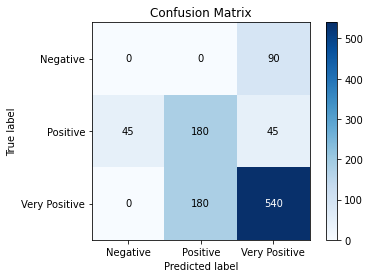

In [ ]:
plot_confusion_matrix(y_test,predictions)

##**LDA Topic Modeling**

Applying LDA model to find each document topic distribution and the high probability of word in each topic. Here, we want to specifically look at the negative reviews to find out what aspects should the hotel be focusing on improving.

Steps to find the optimal LDA model:

1. Convert the reviews to document-term matrix

2. GridSearch and tune for the optimal LDA model

3. Output the optimal lda model and its parameters

4. Compare LDA Model Performance Scores

A line plot to show the LDA model performance scores of with different params

In [ ]:
#Create a function to build the optimal LDA model
def optimal_lda_model(df_review, review_colname):
    docs_raw = df_review[review_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                    stop_words = 'english',
                                    lowercase = True,
                                    token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                                    max_df = 0.9,                        # discard words that appear in > 90% of the reviews
                                    min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], review_colname, dtm_tfidf.shape[1]))

    
    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Define Search Param
    search_params = {'n_components': [5, 10, 15, 20, 25, 30], 
                     'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm_tfidf)


    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))


    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelyhoods from Grid Search Output
    gscore=model.fit(dtm_tfidf).cv_results_
    n_topics = [5, 10, 15, 20, 25, 30]

    log_likelyhoods_5 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.5]
    log_likelyhoods_7 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.7]
    log_likelyhoods_9 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.9]

    # Show graph
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return best_lda_model, dtm_tfidf, tfidf_vectorizer

The shape of the tfidf is (1035, 130), meaning that there are 1035 negative_reviews and 130 tokens made through the filtering process.
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 15}
Model Log Likelihood Score:  -2706.138371903603
Model Perplexity:  74.24034163527627


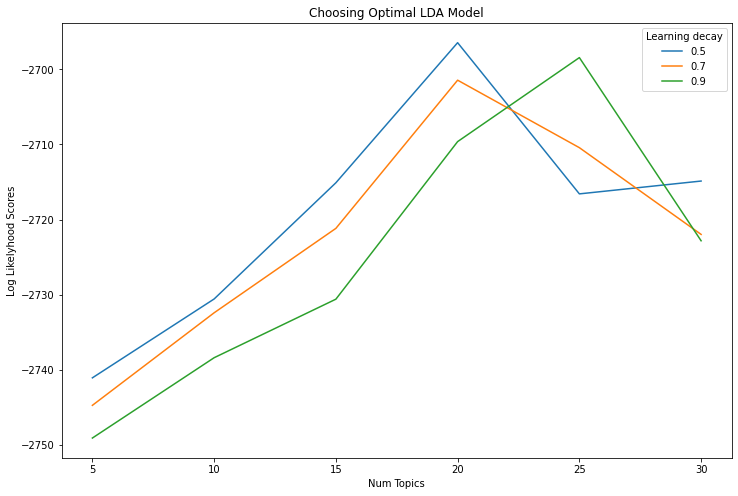

In [ ]:
best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(df_neg_reviews, 'negative_reviews')

From the graph, we see that there is little impact to choose different learning decay.

5 topics would produce the best model.

In [ ]:

#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


display_topics(best_lda_model, tfidf_vectorizer.get_feature_names(), n_top_words = 20)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights,Topic 10 words,Topic 10 weights,Topic 11 words,Topic 11 weights,Topic 12 words,Topic 12 weights,Topic 13 words,Topic 13 weights,Topic 14 words,Topic 14 weights,Topic 15 words,Topic 15 weights
0,room,0.1,low,23.5,like,27.9,toilet,24.8,work,33.7,upkeep,18.9,bathroom,22.9,walls,31.9,stuffy,24.0,able,15.8,shame,27.5,elevators,26.0,internet,20.2,room,0.1,machine,26.0
1,parking,0.1,shower,23.5,charge,23.3,snacks,13.3,didn,29.8,paint,18.9,door,22.9,soundproof,31.9,kinder,24.0,available,15.8,restaurants,27.5,forced,26.0,added,20.2,parking,0.1,rip,26.0
2,little,0.1,pressure,23.5,didn,20.6,improvements,13.3,parking,24.3,general,18.9,suppose,22.6,money,29.3,staff,24.0,day,15.8,open,22.9,wait,26.0,car,20.2,little,0.1,vending,26.0
3,great,0.1,water,19.6,parking,17.1,area,13.3,restaurant,23.2,just,9.5,bar,22.6,expensive,29.3,great,21.1,mini,15.8,room,0.1,room,0.1,charged,20.2,great,0.1,paying,19.3
4,rooms,0.1,trouble,17.6,room,0.1,think,13.3,closed,23.2,better,9.5,prices,22.6,parking,18.0,world,18.3,returned,15.8,parking,0.1,parking,0.1,park,20.2,rooms,0.1,wifi,19.3
5,water,0.1,figuring,17.6,little,0.1,buy,13.3,high,22.4,hallways,9.5,drink,22.6,room,0.1,games,18.3,fridge,13.2,little,0.1,little,0.1,room,0.1,water,0.1,dollar,19.3
6,paid,0.1,bit,17.6,great,0.1,toiletries,13.3,fee,22.4,cleanliness,9.5,using,15.3,little,0.1,watch,18.3,drinks,13.2,great,0.1,great,0.1,parking,0.1,paid,0.1,ready,16.3
7,clean,0.1,switch,17.6,rooms,0.1,maybe,13.3,microwave,22.4,elevator,9.5,room,9.4,great,0.1,series,18.3,wish,13.2,rooms,0.1,rooms,0.1,little,0.1,clean,0.1,slippers,16.3
8,machine,0.1,heating,17.6,water,0.1,view,13.3,fridge,18.7,overall,9.5,lights,7.7,rooms,0.1,nfl,18.3,cold,13.2,water,0.1,water,0.1,great,0.1,machine,0.1,curtain,16.3
9,rip,0.1,cold,14.7,paid,0.1,later,13.3,attendant,17.3,coming,9.5,doesn,7.7,water,0.1,little,17.7,room,9.7,paid,0.1,paid,0.1,rooms,0.1,rip,0.1,prevent,16.3


###**Visualize the topics with pyLDAVis Visualization!**

On the left-hand side of the visualization, each topic is represented by a bubble. The larger the bubble, the more prevalent is that topic.

The distance between two bubbles represents the topic similarity.


The right-hand side shows the top-30 most relevant terms for the topic selected on the left. 

The blue bar represents the overall term frequency, and the red bar indicates the estimated term frequency within the selected topic. 

So, if you see a bar with both red and blue, it means the term also appears at other topics. 

###**Interactive Visualization through slider**

In [ ]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.045223 -0.101657       1        1  11.651739
4     -0.282878 -0.012606       2        1  11.133343
3      0.037073 -0.288715       3        1  11.070934
14     0.101950  0.232764       4        1  10.816142
6      0.161763  0.140657       5        1   9.083236
1      0.175491  0.111482       6        1   7.842749
5      0.019509 -0.093688       7        1   6.901944
9      0.126802  0.078675       8        1   6.066817
7     -0.236818  0.090717       9        1   5.222205
12     0.035170 -0.031134      10        1   4.607491
2     -0.271186  0.137729      11        1   4.187040
11     0.033894 -0.028939      12        1   3.821602
10     0.043531 -0.162620      13        1   3.812625
0      0.050460 -0.036333      14        1   1.891066
13     0.050460 -0.036333      15        1   1.891066, topic_info=            Term       Freq      Total Category  logprob  loglift
29          didn  49.000000  49.000000  Default  30.0000  30.0000
101        shame  32.000000  32.000000  Default  29.0000  29.0000
93   restaurants  32.000000  32.000000  Default  28.0000  28.0000
82       parking  64.000000  64.000000  Default  27.0000  27.0000
76          open  37.000000  37.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
76          open   0.372332  37.455793  Topic15  -4.8675  -0.6431
128         work   0.372332  29.716644  Topic15  -4.8675  -0.4116
47         games   0.372332  16.928347  Topic15  -4.8675   0.1511
73           nfl   0.372332  16.928347  Topic15  -4.8675   0.1511
100       series   0.372332  16.928347  Topic15  -4.8675   0.1511

[775 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         8  0.892281      able
1        10  0.944132     added
2         3  0.860648  answered
3         3  0.881729      area
4         2  0.877274       arm
...     ...       ...       ...
126       4  0.905626      wifi
127       5  0.286378      wish
127       8  0.668216      wish
128       2  0.942233      work
129       1  0.886088     world

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 4, 15, 7, 2, 6, 10, 8, 13, 3, 12, 11, 1, 14])

##**Conclusion**

*   The train dataset used to train the model provides a good prediction for the hotel reviews whether they are positive, negative, very positive or very negative.

*   The accuracy of the prediction is around 70% which is considered good.

*   From the Sentiment Analysis scatter plot, we see that positive reviews are slightly more than the negatives.  
*   Hotel Hilton definitely needs to improve hotel guest satisfaction.

*   The WordCloud reveals some problems for the hotel manager to look into, like their breakfast.

*   The hotel manager should train staff well to provide friendlier and better services.

*   The hotel may also need to work with issues related to soundproofing, air conditioning, shower system and parking.

*   The EDA section could give the hotel manager a general idea of the reviews as well as the rating distribution. 

*   The pyLDAvis interactive visualization would help the hotel manager to further understand what most popular topics within the negative reviews are and make improvements accordingly.








 



 

 



